# Bereitstellung von Chemikalien II

Die Pharmafirma Boring International möchte die Versorgung ihres Betriebsgeländes mit chemischen Rohstoffen von einem Außenlager optimieren. Jeder Tag ist eingeteilt in gewisse Zeiteinheiten. Zu jeder Zeiteinheit kann ein Bedarf an einem bestimmten Rohstoff auf dem Betriebsgelände vorliegen. Um den Bedarf zu decken, verkehren Lastwagen zwischen Außenlager und Betriebsgelände. Rohstoffe, die der Lastwagen transportiert, können entweder direkt genutzt werden, um den Bedarf zu befriedigen, oder sie können zwischengelagert werden, um einen späteren Bedarf zu decken. Das Zwischenlager hat eine begrenzte Lagerkapazität, jeder Lastwagen hat ebenfalls eine beschränkte Transportkapazität.  
Jede Fahrt verursacht Kosten. Diese sollen minimiert werden.

**NEU** Es stehen mehrere Lastwagen zur Verfügung. 
Das Außenlager ist weiter entfernt: 
Jeder Lastwagen braucht $r$ Zeiteinheiten für eine Fahrt von Betriebsgelände zum Außenlager und zurück. D.h. zwischen zwei Lieferungen eines Lastwagens
müssen mindestens $r$ Zeiteinheiten liegen. Zudem gibt es Rohstoffe, die nicht zusammen in einem Lastwagen transportiert werden dürfen (z.B. Wasserstoff und Sauerstoff), etwa weil bei einem Unfall dann Explosionsgefahr bestünde.

Jede Instanz ist durch folgende Daten charakterisiert: 
* Die Menge der Rohstoffe (Chemikalien): $\mathcal C$
* Kapazität des Zwischenlagers: $B$
* Die Zeitperioden: $1,...,T$
* Bedarf zum Zeitpunkt $t$ an Rohstoff $c$: $d_{ct}$
* Dauer der Transportfahrt: $r$
* Kosten einer Fahrt: $g$ 
* Kapazität der Lieferwagen: $h$
* Anzahl der Lieferwagen: $k$
* Menge von Paaren von Rohstoffen, die nicht zusammen transportiert werden dürfen: $\mathcal I$

Variablen:
* $z_{tv}\in\{0,1\}$: Indikator, ob zum Zeitpunkt $t$ eine Lieferung mit Lastwagen $v$ stattfindet
* $x_{ctv}\geq 0$: Menge an Rohstoff $c$, der zu Beginn von Periode $t$ per Lastwagen $v$ angeliefert wird
* $y_{ctv}\in\{0,1\}$: Indikator, ob Lastwagen $v$ zu Beginn von Periode $t$ den Rohstoff $c$ anliefert
* $p_{ct}\geq 0$: Menge an Rohstoff $c$, der zum Ende von Periode $t$ im Zwischenlager vorhanden ist 

\begin{align}
\min\, & g\sum_{t=1}^T\sum_{v=1}^k z_{tv} & (1) \\
& \sum_{c\in\mathcal C} p_{ct}\leq B\quad\text{für alle }t=1,\ldots T & (2)  \\
& \sum_{c\in\mathcal C}x_{ctv}\leq hz_{tv}\quad\text{für alle }t=1,\ldots T, v=1,\ldots,k & (3)  \\
& x_{ctv}\leq hy_{ctv}\quad\text{für alle }c,t,v & (4) \\
& y_{ctv}+y_{c'tv}\leq 1\quad\text{für alle }(c,c')\in I,t,v & (5) \\
& p_{ct} + d_{ct} = p_{c,t-1}+\sum_{v=1}^kx_{ctv}\quad\text{für alle } t=1,\ldots T,c\in\mathcal C & (6) \\
& p_{c0} =0\quad\text{für alle }c\in\mathcal C & (7) \\
& \sum_{i=t-r+1}^tz_{iv}\leq 1\quad\text{für alle }t=r,\ldots,T & (8) 
\end{align}


Wir laden nötige Dateien und machen zwei nötige <code>import</code>. Die Ausgabe wird kompliziert aussehen -- einfach ignorieren! Wenn Sie lokal auf Ihrem Rechner arbeiten, mip installiert haben und chm.py in das gleiche Verzeichnis gelegt haben, kommentieren Sie die ersten beiden Zeilen aus. 

In [1]:
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/chem_aufgabe/chm.py
!pip install mip
    
import mip   ## Der mip-solver
import chm   ## Code zur Instanzenerzeugung und zur graphischen Darstellung

Using Python-MIP package version 1.8.1


Wir beschaffen uns die Instanz <code>inst</code>, mit der Sie arbeiten sollen.

In [2]:
inst=chm.get_instance2()
print(inst)

C Anzahl Rohstoffe: ...................4
T Anzahl Zeitperioden: ................12
B Kapazität des Zwischenlagers: .......100
g Kosten einer Fahrt: .................1
h Kapazität der Lastwagen: ............10
d Gesamtbedarf über alle Zeitperioden: 245.0
k Anzahl der Lastwagen: ...............7
r Fahrtzeit der Lastwagen: ............3
I gefährliche Rohstoffpaare: ..........[(0, 2), (0, 3)]



Wir zeigen uns wieder den Bedarf an:

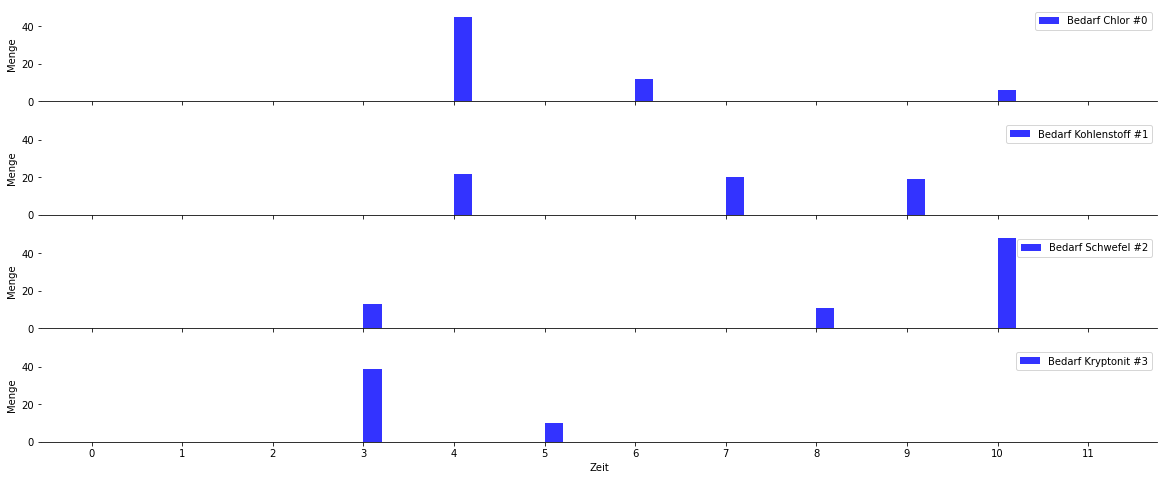

In [3]:
chm.show_demand(inst)

## Das Modell

Wir starten wieder mit den Variablen:

In [4]:
m=mip.Model()
p=[[m.add_var() for _ in range(inst.T)] for _ in range(inst.C)]
x=[[[m.add_var() for _ in range(inst.k)] for _ in range(inst.T)] for _ in range(inst.C)]
y=[[[m.add_var(var_type=mip.BINARY) for _ in range(inst.k)] for _ in range(inst.T)] for _ in range(inst.C)]
z=[[m.add_var(var_type=mip.BINARY) for _ in range(inst.k)] for _ in range(inst.T)]

Bedingung (2):

In [5]:
for t in range(inst.T):
    m+=mip.xsum(p[c][t] for c in range(inst.C))<=inst.B

Bedingung (3):

In [6]:
for t in range(inst.T):
    for v in range(inst.k):    
        m+=mip.xsum(x[c][t][v] for c in range(inst.C))<=z[t][v]*inst.h

Bedingung (4):

In [7]:
for c in range(inst.C):
    for t in range(inst.T):
        for v in range(inst.k):    
            m+=x[c][t][v]<=inst.h*y[c][t][v]

Bedingung (5):

In [8]:
for c,cc in inst.I:
    for t in range(inst.T):
        for v in range(inst.k):
            m+=y[c][t][v]+y[cc][t][v]<=1

Bedingungen (6) und (7):

In [9]:
for c in range(inst.C):
    m+=p[c][0]+inst.d[c][0]==mip.xsum(x[c][0][v] for v in range(inst.k))
for t in range(1,inst.T):
    for c in range(inst.C):
        m+=p[c][t]+inst.d[c][t]==p[c][t-1]+mip.xsum(x[c][t][v] for v in range(inst.k)) 

Bedingung (8):

In [10]:
for t in range(inst.T):
    for v in range(inst.k):
        start=max(0,t-inst.r+1)
        m+=mip.xsum(z[i][v] for i in range(start,t+1))<=1

Die Zielfunktion (1):

In [11]:
m.objective=mip.minimize(mip.xsum(inst.g*z[t][v] for t in range(inst.T) for v in range(inst.k)))
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

## Lösung

Schauen wir uns erst die Übersicht an:

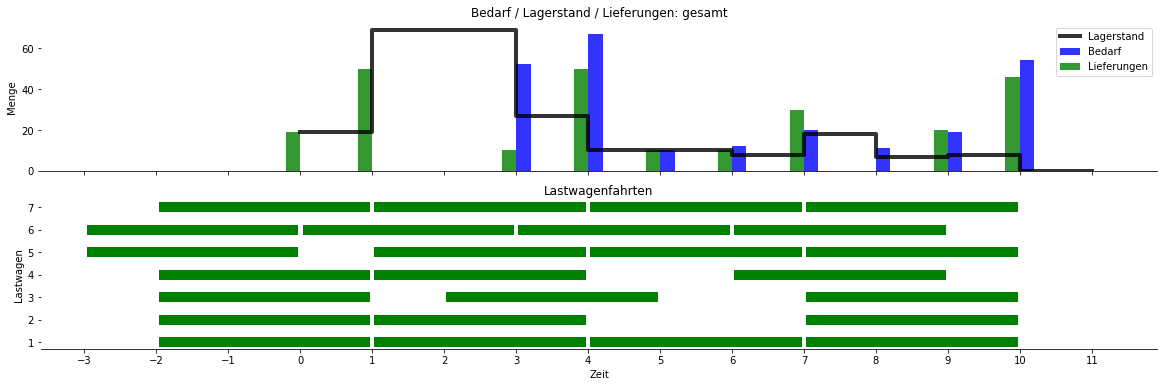

In [12]:
chm.show_solution2(x,z,p,inst,chemical='all')

Nun schauen wir uns zwei Rohstoffe an, die nicht zusammen transportiert werden dürfen:

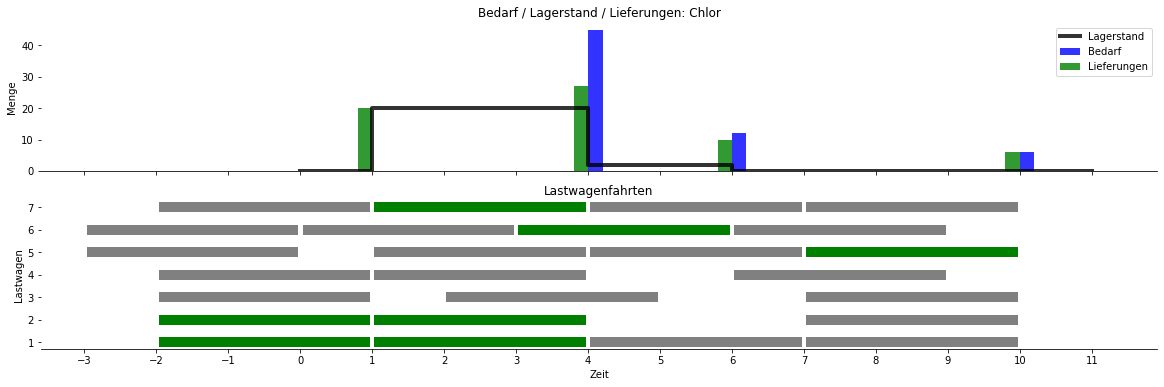

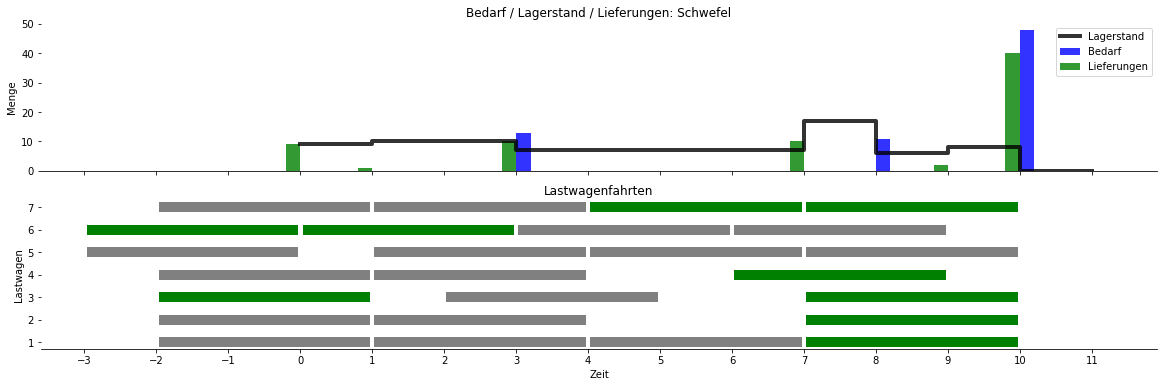

In [13]:
chm.show_solution2(x,z,p,inst,chemical="Chlor")
chm.show_solution2(x,z,p,inst,chemical="Schwefel")